In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
from PIL import Image
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "alphabet"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 198

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
# from PIL import Image
# import cv2
# img = cv2.imread('grayscale_images/images/Gayathri-Regular_90.png')
# print(img.shape)

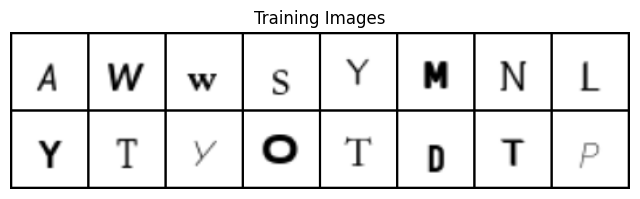

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Grayscale(1)
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
# print(np.shape(real_batch))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
# print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
!pip install torchsummary 

In [11]:
from torchsummary import summary
summary(netG,(128,1,1))
# nz

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(beta1, 0.999),weight_decay = 0.1)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(beta1, 0.999),weight_decay = 0.0)

sample_dir = 'generated_alphabets'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
        fake_images = vutils.make_grid(fake_images, padding=2, normalize=True)
        fake_images = np.transpose(fake_images,(1,2,0)).numpy()
        fake_images = Image.fromarray((fake_images * 255).astype('uint8'))
        # print(fake_images.shape())
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        fake_images.save(os.path.join(sample_dir, fake_fname))
        # save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
        # print('Saving', fake_fname)
    # if show:
    #     fig, ax = plt.subplots(figsize=(8, 8))
    #     ax.set_xticks([]); ax.set_yticks([])
    #     ax.imshow(make_grid(fake_images, nrow=8).permute(1, 2, 0))
    # print(fake_images.shape)
    # plt.imshow(fake_images)
    # plt.show()

In [ ]:
# Training Loop
from tqdm import tqdm 
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(dataloader), 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        # if i % 50 == 0:
            # print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            #       % (epoch, num_epochs, i, len(dataloader),
            #          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
                # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1
        
    save_samples(epoch+1, nz, show=False)
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch+1, num_epochs, i+1, len(dataloader),errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))



Starting Training Loop...


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 29.77it/s]


[1/198][108/108]	Loss_D: 0.0000	Loss_G: 32.3807	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.47it/s]


[2/198][108/108]	Loss_D: 0.5876	Loss_G: 12.2368	D(x): 0.9986	D(G(z)): 0.4005 / 0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.26it/s]


[3/198][108/108]	Loss_D: 0.0566	Loss_G: 6.0337	D(x): 0.9565	D(G(z)): 0.0114 / 0.0052


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.33it/s]


[4/198][108/108]	Loss_D: 0.4106	Loss_G: 3.6429	D(x): 0.7884	D(G(z)): 0.0446 / 0.0397


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.28it/s]


[5/198][108/108]	Loss_D: 1.9035	Loss_G: 1.1853	D(x): 0.4219	D(G(z)): 0.1003 / 0.3521


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.42it/s]


[6/198][108/108]	Loss_D: 0.0533	Loss_G: 5.7776	D(x): 0.9530	D(G(z)): 0.0043 / 0.0070


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.73it/s]


[7/198][108/108]	Loss_D: 0.0706	Loss_G: 4.8812	D(x): 0.9792	D(G(z)): 0.0467 / 0.0102


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.14it/s]


[8/198][108/108]	Loss_D: 0.1000	Loss_G: 8.0782	D(x): 0.9975	D(G(z)): 0.0913 / 0.0004


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.19it/s]


[9/198][108/108]	Loss_D: 0.8392	Loss_G: 8.6484	D(x): 0.9866	D(G(z)): 0.5339 / 0.0018


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.99it/s]


[10/198][108/108]	Loss_D: 0.0917	Loss_G: 5.1949	D(x): 0.9793	D(G(z)): 0.0671 / 0.0064


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.51it/s]


[11/198][108/108]	Loss_D: 0.0358	Loss_G: 6.0581	D(x): 0.9993	D(G(z)): 0.0342 / 0.0024


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.17it/s]


[12/198][108/108]	Loss_D: 0.9469	Loss_G: 8.8558	D(x): 0.9453	D(G(z)): 0.5067 / 0.0004


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.26it/s]


[13/198][108/108]	Loss_D: 0.0170	Loss_G: 6.0564	D(x): 0.9857	D(G(z)): 0.0024 / 0.0029


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.16it/s]


[14/198][108/108]	Loss_D: 0.3162	Loss_G: 1.0338	D(x): 0.7589	D(G(z)): 0.0046 / 0.4388


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.04it/s]


[15/198][108/108]	Loss_D: 0.0666	Loss_G: 5.5639	D(x): 0.9938	D(G(z)): 0.0584 / 0.0041


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.89it/s]


[16/198][108/108]	Loss_D: 0.7726	Loss_G: 2.7315	D(x): 0.6011	D(G(z)): 0.2271 / 0.0663


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.26it/s]


[17/198][108/108]	Loss_D: 1.2109	Loss_G: 1.8503	D(x): 0.3634	D(G(z)): 0.0116 / 0.3839


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.21it/s]


[18/198][108/108]	Loss_D: 0.2106	Loss_G: 9.6656	D(x): 0.9914	D(G(z)): 0.1774 / 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.91it/s]


[19/198][108/108]	Loss_D: 0.0204	Loss_G: 6.9389	D(x): 0.9824	D(G(z)): 0.0025 / 0.0016


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.45it/s]


[20/198][108/108]	Loss_D: 0.3369	Loss_G: 7.5538	D(x): 0.9872	D(G(z)): 0.2599 / 0.0007


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.94it/s]


[21/198][108/108]	Loss_D: 1.4661	Loss_G: 0.8977	D(x): 0.2794	D(G(z)): 0.0563 / 0.4552


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.11it/s]


[22/198][108/108]	Loss_D: 1.2272	Loss_G: 11.1330	D(x): 0.9556	D(G(z)): 0.6646 / 0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.62it/s]


[23/198][108/108]	Loss_D: 0.0169	Loss_G: 8.9876	D(x): 0.9836	D(G(z)): 0.0003 / 0.0002


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.32it/s]


[24/198][108/108]	Loss_D: 0.1957	Loss_G: 3.5257	D(x): 0.8627	D(G(z)): 0.0450 / 0.0311


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.33it/s]


[25/198][108/108]	Loss_D: 1.0301	Loss_G: 2.5832	D(x): 0.5370	D(G(z)): 0.1832 / 0.0865


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.44it/s]


[26/198][108/108]	Loss_D: 0.0111	Loss_G: 7.1958	D(x): 0.9980	D(G(z)): 0.0091 / 0.0014


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.53it/s]


[27/198][108/108]	Loss_D: 3.2569	Loss_G: 1.7964	D(x): 0.0402	D(G(z)): 0.0079 / 0.2055


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.70it/s]


[28/198][108/108]	Loss_D: 2.4545	Loss_G: 0.0394	D(x): 0.1190	D(G(z)): 0.0369 / 0.9615


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.02it/s]


[29/198][108/108]	Loss_D: 0.3061	Loss_G: 4.7448	D(x): 0.8851	D(G(z)): 0.1484 / 0.0092


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.26it/s]


[30/198][108/108]	Loss_D: 1.4981	Loss_G: 6.7606	D(x): 0.9318	D(G(z)): 0.7373 / 0.0014


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.05it/s]


[31/198][108/108]	Loss_D: 0.2132	Loss_G: 4.3800	D(x): 0.9009	D(G(z)): 0.0963 / 0.0129


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.10it/s]


[32/198][108/108]	Loss_D: 1.2323	Loss_G: 5.2151	D(x): 0.6681	D(G(z)): 0.5059 / 0.0064


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.21it/s]


[33/198][108/108]	Loss_D: 0.4526	Loss_G: 3.0545	D(x): 0.9262	D(G(z)): 0.3086 / 0.0482


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.72it/s]


[34/198][108/108]	Loss_D: 0.0416	Loss_G: 5.1743	D(x): 0.9664	D(G(z)): 0.0065 / 0.0093


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.03it/s]


[35/198][108/108]	Loss_D: 0.0181	Loss_G: 6.1742	D(x): 0.9872	D(G(z)): 0.0052 / 0.0024


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.35it/s]


[36/198][108/108]	Loss_D: 0.0031	Loss_G: 6.7591	D(x): 0.9986	D(G(z)): 0.0018 / 0.0012


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.19it/s]


[37/198][108/108]	Loss_D: 0.0020	Loss_G: 7.3218	D(x): 0.9994	D(G(z)): 0.0013 / 0.0007


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.03it/s]


[38/198][108/108]	Loss_D: 0.1961	Loss_G: 4.4755	D(x): 0.8575	D(G(z)): 0.0126 / 0.0120


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.09it/s]


[39/198][108/108]	Loss_D: 0.0309	Loss_G: 4.8491	D(x): 0.9800	D(G(z)): 0.0104 / 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.08it/s]


[40/198][108/108]	Loss_D: 1.5054	Loss_G: 2.7298	D(x): 0.4439	D(G(z)): 0.4185 / 0.0801


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.18it/s]


[41/198][108/108]	Loss_D: 0.5793	Loss_G: 3.3175	D(x): 0.8170	D(G(z)): 0.2810 / 0.0373


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.87it/s]


[42/198][108/108]	Loss_D: 1.1176	Loss_G: 5.4559	D(x): 0.8272	D(G(z)): 0.5547 / 0.0046


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.04it/s]


[43/198][108/108]	Loss_D: 0.2489	Loss_G: 0.7781	D(x): 0.8057	D(G(z)): 0.0305 / 0.4690


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.77it/s]


[44/198][108/108]	Loss_D: 0.1553	Loss_G: 4.9636	D(x): 0.9394	D(G(z)): 0.0846 / 0.0077


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.90it/s]


[45/198][108/108]	Loss_D: 0.0250	Loss_G: 6.5962	D(x): 0.9778	D(G(z)): 0.0024 / 0.0016


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.29it/s]


[46/198][108/108]	Loss_D: 0.2999	Loss_G: 2.5223	D(x): 0.9078	D(G(z)): 0.1765 / 0.0818


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.27it/s]


[47/198][108/108]	Loss_D: 0.2689	Loss_G: 4.3850	D(x): 0.8717	D(G(z)): 0.1097 / 0.0131


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.43it/s]


[48/198][108/108]	Loss_D: 0.0315	Loss_G: 5.6186	D(x): 0.9837	D(G(z)): 0.0149 / 0.0038


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.79it/s]


[49/198][108/108]	Loss_D: 0.7394	Loss_G: 0.8087	D(x): 0.5160	D(G(z)): 0.0127 / 0.4489


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.08it/s]


[50/198][108/108]	Loss_D: 0.0791	Loss_G: 4.2926	D(x): 0.9624	D(G(z)): 0.0389 / 0.0151


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.06it/s]


[51/198][108/108]	Loss_D: 2.1045	Loss_G: 3.6285	D(x): 0.8523	D(G(z)): 0.8423 / 0.0410


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.15it/s]


[52/198][108/108]	Loss_D: 0.0444	Loss_G: 5.0425	D(x): 0.9816	D(G(z)): 0.0252 / 0.0071


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.81it/s]


[53/198][108/108]	Loss_D: 0.4833	Loss_G: 2.7148	D(x): 0.7152	D(G(z)): 0.1303 / 0.0666


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.12it/s]


[54/198][108/108]	Loss_D: 0.1070	Loss_G: 3.7586	D(x): 0.9263	D(G(z)): 0.0296 / 0.0256


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.89it/s]


[55/198][108/108]	Loss_D: 0.6261	Loss_G: 2.3669	D(x): 0.8494	D(G(z)): 0.3560 / 0.0973


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.86it/s]


[56/198][108/108]	Loss_D: 1.0172	Loss_G: 4.1548	D(x): 0.9557	D(G(z)): 0.5916 / 0.0172


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.21it/s]


[57/198][108/108]	Loss_D: 0.3913	Loss_G: 4.6212	D(x): 0.9452	D(G(z)): 0.2557 / 0.0099


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.85it/s]


[58/198][108/108]	Loss_D: 0.1015	Loss_G: 4.5512	D(x): 0.9517	D(G(z)): 0.0490 / 0.0107


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.03it/s]


[59/198][108/108]	Loss_D: 0.0871	Loss_G: 3.9254	D(x): 0.9405	D(G(z)): 0.0250 / 0.0202


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.11it/s]


[60/198][108/108]	Loss_D: 0.0613	Loss_G: 4.4967	D(x): 0.9628	D(G(z)): 0.0229 / 0.0117


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.79it/s]


[61/198][108/108]	Loss_D: 0.4183	Loss_G: 2.7376	D(x): 0.7576	D(G(z)): 0.1209 / 0.0690


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.71it/s]


[62/198][108/108]	Loss_D: 0.1862	Loss_G: 4.2218	D(x): 0.9384	D(G(z)): 0.1137 / 0.0154


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.14it/s]


[63/198][108/108]	Loss_D: 0.2347	Loss_G: 3.9220	D(x): 0.9573	D(G(z)): 0.1724 / 0.0202


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.80it/s]


[64/198][108/108]	Loss_D: 0.1304	Loss_G: 3.4122	D(x): 0.9737	D(G(z)): 0.0959 / 0.0345


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.87it/s]


[65/198][108/108]	Loss_D: 1.0708	Loss_G: 0.5182	D(x): 0.3715	D(G(z)): 0.0560 / 0.6146


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.95it/s]


[66/198][108/108]	Loss_D: 0.1391	Loss_G: 3.4529	D(x): 0.9110	D(G(z)): 0.0439 / 0.0330


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.59it/s]


[67/198][108/108]	Loss_D: 0.0723	Loss_G: 4.0588	D(x): 0.9495	D(G(z)): 0.0195 / 0.0178


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.12it/s]


[68/198][108/108]	Loss_D: 0.6333	Loss_G: 2.9196	D(x): 0.8432	D(G(z)): 0.3566 / 0.0561


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.14it/s]


[69/198][108/108]	Loss_D: 0.8134	Loss_G: 3.5564	D(x): 0.8979	D(G(z)): 0.4931 / 0.0308


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.14it/s]


[70/198][108/108]	Loss_D: 0.0774	Loss_G: 3.7277	D(x): 0.9686	D(G(z)): 0.0443 / 0.0243


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.57it/s]


[71/198][108/108]	Loss_D: 0.0769	Loss_G: 4.4501	D(x): 0.9752	D(G(z)): 0.0501 / 0.0118


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.54it/s]


[72/198][108/108]	Loss_D: 0.9709	Loss_G: 3.4987	D(x): 0.9264	D(G(z)): 0.5590 / 0.0311


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.95it/s]


[73/198][108/108]	Loss_D: 0.2777	Loss_G: 2.2740	D(x): 0.8355	D(G(z)): 0.0895 / 0.1112


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.06it/s]


[74/198][108/108]	Loss_D: 0.0544	Loss_G: 4.0291	D(x): 0.9681	D(G(z)): 0.0216 / 0.0200


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.70it/s]


[75/198][108/108]	Loss_D: 0.9596	Loss_G: 3.2549	D(x): 0.9062	D(G(z)): 0.5684 / 0.0426


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.06it/s]


[76/198][108/108]	Loss_D: 1.8828	Loss_G: 2.7255	D(x): 0.1579	D(G(z)): 0.0265 / 0.0757


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.13it/s]


[77/198][108/108]	Loss_D: 0.0584	Loss_G: 3.7991	D(x): 0.9783	D(G(z)): 0.0357 / 0.0233


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.92it/s]


[78/198][108/108]	Loss_D: 0.8064	Loss_G: 2.6940	D(x): 0.9495	D(G(z)): 0.5062 / 0.0696


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.72it/s]


[79/198][108/108]	Loss_D: 0.2263	Loss_G: 3.8904	D(x): 0.9569	D(G(z)): 0.1519 / 0.0209


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.13it/s]


[80/198][108/108]	Loss_D: 0.3963	Loss_G: 4.9401	D(x): 0.9788	D(G(z)): 0.2956 / 0.0074


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.96it/s]


[81/198][108/108]	Loss_D: 0.4779	Loss_G: 4.3730	D(x): 0.9271	D(G(z)): 0.3175 / 0.0127


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.88it/s]


[82/198][108/108]	Loss_D: 0.2355	Loss_G: 1.5463	D(x): 0.8116	D(G(z)): 0.0192 / 0.2256


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.57it/s]


[83/198][108/108]	Loss_D: 0.1090	Loss_G: 3.8941	D(x): 0.9526	D(G(z)): 0.0578 / 0.0205


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.06it/s]


[84/198][108/108]	Loss_D: 1.9520	Loss_G: 1.7904	D(x): 0.6803	D(G(z)): 0.7774 / 0.1676


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.61it/s]


[85/198][108/108]	Loss_D: 0.1402	Loss_G: 4.6891	D(x): 0.9692	D(G(z)): 0.1023 / 0.0095


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 31.08it/s]


[86/198][108/108]	Loss_D: 2.4096	Loss_G: 2.4182	D(x): 0.1095	D(G(z)): 0.0203 / 0.0943


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 26.79it/s]


[87/198][108/108]	Loss_D: 0.0948	Loss_G: 3.4927	D(x): 0.9374	D(G(z)): 0.0289 / 0.0324


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.63it/s]


[88/198][108/108]	Loss_D: 0.0906	Loss_G: 3.8730	D(x): 0.9542	D(G(z)): 0.0425 / 0.0219


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.98it/s]


[89/198][108/108]	Loss_D: 0.0417	Loss_G: 4.3066	D(x): 0.9753	D(G(z)): 0.0165 / 0.0140


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.77it/s]


[90/198][108/108]	Loss_D: 0.1970	Loss_G: 3.2947	D(x): 0.9036	D(G(z)): 0.0890 / 0.0386


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.36it/s]


[91/198][108/108]	Loss_D: 0.0762	Loss_G: 3.8928	D(x): 0.9602	D(G(z)): 0.0348 / 0.0210


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.51it/s]


[92/198][108/108]	Loss_D: 0.2771	Loss_G: 2.0443	D(x): 0.9147	D(G(z)): 0.1682 / 0.1341


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.35it/s]


[93/198][108/108]	Loss_D: 0.0576	Loss_G: 3.6542	D(x): 0.9760	D(G(z)): 0.0327 / 0.0262


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.56it/s]


[94/198][108/108]	Loss_D: 0.0929	Loss_G: 3.6398	D(x): 0.9379	D(G(z)): 0.0270 / 0.0320


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.84it/s]


[95/198][108/108]	Loss_D: 0.0693	Loss_G: 3.6449	D(x): 0.9595	D(G(z)): 0.0273 / 0.0289


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.21it/s]


[96/198][108/108]	Loss_D: 1.3289	Loss_G: 3.6455	D(x): 0.9292	D(G(z)): 0.7088 / 0.0266


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.06it/s]


[97/198][108/108]	Loss_D: 0.1399	Loss_G: 3.9149	D(x): 0.9497	D(G(z)): 0.0836 / 0.0203


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.81it/s]


[98/198][108/108]	Loss_D: 0.2387	Loss_G: 3.4370	D(x): 0.8354	D(G(z)): 0.0537 / 0.0337


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.88it/s]


[99/198][108/108]	Loss_D: 0.0889	Loss_G: 3.7548	D(x): 0.9755	D(G(z)): 0.0614 / 0.0246


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.70it/s]


[100/198][108/108]	Loss_D: 0.0753	Loss_G: 4.2773	D(x): 0.9838	D(G(z)): 0.0569 / 0.0141


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.70it/s]


[101/198][108/108]	Loss_D: 0.6720	Loss_G: 2.6629	D(x): 0.7417	D(G(z)): 0.2995 / 0.0726


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.60it/s]


[102/198][108/108]	Loss_D: 0.4713	Loss_G: 3.3885	D(x): 0.7593	D(G(z)): 0.1667 / 0.0354


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.52it/s]


[103/198][108/108]	Loss_D: 0.1259	Loss_G: 3.3295	D(x): 0.9151	D(G(z)): 0.0350 / 0.0387


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.80it/s]


[104/198][108/108]	Loss_D: 0.0826	Loss_G: 3.8377	D(x): 0.9541	D(G(z)): 0.0347 / 0.0228


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.84it/s]


[105/198][108/108]	Loss_D: 2.2393	Loss_G: 2.2414	D(x): 0.1178	D(G(z)): 0.0283 / 0.1096


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.53it/s]


[106/198][108/108]	Loss_D: 0.8638	Loss_G: 2.3674	D(x): 0.4872	D(G(z)): 0.0936 / 0.1045


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.22it/s]


[107/198][108/108]	Loss_D: 0.0909	Loss_G: 3.7560	D(x): 0.9596	D(G(z)): 0.0482 / 0.0239


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.71it/s]


[108/198][108/108]	Loss_D: 1.1169	Loss_G: 1.4188	D(x): 0.5781	D(G(z)): 0.4129 / 0.2454


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.60it/s]


[109/198][108/108]	Loss_D: 0.5931	Loss_G: 0.9859	D(x): 0.5825	D(G(z)): 0.0227 / 0.3959


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.72it/s]


[110/198][108/108]	Loss_D: 0.1127	Loss_G: 3.4292	D(x): 0.9181	D(G(z)): 0.0258 / 0.0333


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.25it/s]


[111/198][108/108]	Loss_D: 0.8694	Loss_G: 1.1882	D(x): 0.4701	D(G(z)): 0.0328 / 0.3472


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.22it/s]


[112/198][108/108]	Loss_D: 0.1647	Loss_G: 3.3233	D(x): 0.9466	D(G(z)): 0.1029 / 0.0381


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.65it/s]


[113/198][108/108]	Loss_D: 0.0686	Loss_G: 3.9296	D(x): 0.9737	D(G(z)): 0.0409 / 0.0200


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.79it/s]


[114/198][108/108]	Loss_D: 0.3492	Loss_G: 2.8868	D(x): 0.8171	D(G(z)): 0.1315 / 0.0596


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.71it/s]


[115/198][108/108]	Loss_D: 0.1230	Loss_G: 3.9215	D(x): 0.9014	D(G(z)): 0.0175 / 0.0210


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.70it/s]


[116/198][108/108]	Loss_D: 0.0788	Loss_G: 3.8605	D(x): 0.9420	D(G(z)): 0.0183 / 0.0217


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.47it/s]


[117/198][108/108]	Loss_D: 0.4722	Loss_G: 3.1057	D(x): 0.9191	D(G(z)): 0.3125 / 0.0464


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.32it/s]


[118/198][108/108]	Loss_D: 0.3817	Loss_G: 3.0429	D(x): 0.7476	D(G(z)): 0.0740 / 0.0500


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.66it/s]


[119/198][108/108]	Loss_D: 0.0992	Loss_G: 3.5662	D(x): 0.9328	D(G(z)): 0.0281 / 0.0284


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.53it/s]


[120/198][108/108]	Loss_D: 0.0795	Loss_G: 3.8423	D(x): 0.9430	D(G(z)): 0.0201 / 0.0219


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.99it/s]


[121/198][108/108]	Loss_D: 0.0956	Loss_G: 3.1997	D(x): 0.9695	D(G(z)): 0.0623 / 0.0419


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.59it/s]


[122/198][108/108]	Loss_D: 0.0548	Loss_G: 4.0678	D(x): 0.9693	D(G(z)): 0.0232 / 0.0180


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.72it/s]


[123/198][108/108]	Loss_D: 0.0404	Loss_G: 4.1188	D(x): 0.9778	D(G(z)): 0.0177 / 0.0169


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.88it/s]


[124/198][108/108]	Loss_D: 0.3204	Loss_G: 2.5954	D(x): 0.7479	D(G(z)): 0.0136 / 0.0813


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.54it/s]


[125/198][108/108]	Loss_D: 0.6529	Loss_G: 3.5650	D(x): 0.8247	D(G(z)): 0.3599 / 0.0286


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.20it/s]


[126/198][108/108]	Loss_D: 0.1273	Loss_G: 3.5548	D(x): 0.9497	D(G(z)): 0.0716 / 0.0305


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.63it/s]


[127/198][108/108]	Loss_D: 0.2605	Loss_G: 3.7101	D(x): 0.8824	D(G(z)): 0.1235 / 0.0248


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.56it/s]


[128/198][108/108]	Loss_D: 0.0504	Loss_G: 4.1432	D(x): 0.9706	D(G(z)): 0.0203 / 0.0164


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.62it/s]


[129/198][108/108]	Loss_D: 0.0341	Loss_G: 4.2770	D(x): 0.9818	D(G(z)): 0.0156 / 0.0139


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.41it/s]


[130/198][108/108]	Loss_D: 0.0348	Loss_G: 4.2871	D(x): 0.9819	D(G(z)): 0.0164 / 0.0144


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.65it/s]


[131/198][108/108]	Loss_D: 0.0277	Loss_G: 4.3705	D(x): 0.9858	D(G(z)): 0.0133 / 0.0127


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.67it/s]


[132/198][108/108]	Loss_D: 0.0294	Loss_G: 4.3369	D(x): 0.9844	D(G(z)): 0.0136 / 0.0131


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.76it/s]


[133/198][108/108]	Loss_D: 0.0320	Loss_G: 4.2167	D(x): 0.9835	D(G(z)): 0.0152 / 0.0148


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.65it/s]


[134/198][108/108]	Loss_D: 0.0323	Loss_G: 4.2302	D(x): 0.9827	D(G(z)): 0.0147 / 0.0146


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.72it/s]


[135/198][108/108]	Loss_D: 0.0407	Loss_G: 4.0233	D(x): 0.9796	D(G(z)): 0.0199 / 0.0181


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.73it/s]


[136/198][108/108]	Loss_D: 0.0760	Loss_G: 3.6365	D(x): 0.9528	D(G(z)): 0.0258 / 0.0269


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.70it/s]


[137/198][108/108]	Loss_D: 0.9856	Loss_G: 1.4360	D(x): 0.5226	D(G(z)): 0.2665 / 0.2429


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.00it/s]


[138/198][108/108]	Loss_D: 0.8167	Loss_G: 1.8113	D(x): 0.6793	D(G(z)): 0.3068 / 0.1766


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.09it/s]


[139/198][108/108]	Loss_D: 0.6070	Loss_G: 2.8863	D(x): 0.7539	D(G(z)): 0.2730 / 0.0562


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.76it/s]


[140/198][108/108]	Loss_D: 0.6192	Loss_G: 3.3174	D(x): 0.7705	D(G(z)): 0.2922 / 0.0365


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.65it/s]


[141/198][108/108]	Loss_D: 0.4187	Loss_G: 3.4368	D(x): 0.8697	D(G(z)): 0.2410 / 0.0331


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.69it/s]


[142/198][108/108]	Loss_D: 0.0745	Loss_G: 3.8876	D(x): 0.9528	D(G(z)): 0.0255 / 0.0208


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 35.02it/s]


[143/198][108/108]	Loss_D: 0.0674	Loss_G: 4.1359	D(x): 0.9596	D(G(z)): 0.0258 / 0.0162


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.57it/s]


[144/198][108/108]	Loss_D: 0.0466	Loss_G: 4.1205	D(x): 0.9731	D(G(z)): 0.0190 / 0.0165


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.05it/s]


[145/198][108/108]	Loss_D: 0.0321	Loss_G: 4.3183	D(x): 0.9833	D(G(z)): 0.0151 / 0.0136


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.38it/s]


[146/198][108/108]	Loss_D: 1.3558	Loss_G: 1.2421	D(x): 0.3924	D(G(z)): 0.3054 / 0.2912


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.47it/s]


[147/198][108/108]	Loss_D: 1.5746	Loss_G: 1.3483	D(x): 0.2246	D(G(z)): 0.0363 / 0.2626


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.55it/s]


[148/198][108/108]	Loss_D: 0.1462	Loss_G: 3.4056	D(x): 0.9349	D(G(z)): 0.0750 / 0.0336


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.80it/s]


[149/198][108/108]	Loss_D: 2.0926	Loss_G: 1.9750	D(x): 0.1918	D(G(z)): 0.2986 / 0.1469


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.84it/s]


[150/198][108/108]	Loss_D: 0.3372	Loss_G: 2.2951	D(x): 0.8292	D(G(z)): 0.1383 / 0.1047


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.80it/s]


[151/198][108/108]	Loss_D: 0.2146	Loss_G: 2.9479	D(x): 0.8948	D(G(z)): 0.0965 / 0.0530


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.87it/s]


[152/198][108/108]	Loss_D: 0.0478	Loss_G: 3.8753	D(x): 0.9760	D(G(z)): 0.0231 / 0.0211


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.22it/s]


[153/198][108/108]	Loss_D: 0.0267	Loss_G: 4.5126	D(x): 0.9866	D(G(z)): 0.0131 / 0.0110


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.91it/s]


[154/198][108/108]	Loss_D: 0.2066	Loss_G: 3.7525	D(x): 0.9142	D(G(z)): 0.1076 / 0.0236


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.60it/s]


[155/198][108/108]	Loss_D: 0.5631	Loss_G: 2.2927	D(x): 0.6146	D(G(z)): 0.0512 / 0.1192


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.65it/s]


[156/198][108/108]	Loss_D: 0.0695	Loss_G: 3.4520	D(x): 0.9691	D(G(z)): 0.0373 / 0.0327


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.96it/s]


[157/198][108/108]	Loss_D: 0.0539	Loss_G: 3.8459	D(x): 0.9740	D(G(z)): 0.0271 / 0.0222


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.47it/s]


[158/198][108/108]	Loss_D: 1.9047	Loss_G: 0.4939	D(x): 0.1715	D(G(z)): 0.0407 / 0.6302


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.64it/s]


[159/198][108/108]	Loss_D: 1.4449	Loss_G: 3.0183	D(x): 0.9390	D(G(z)): 0.7160 / 0.0508


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.77it/s]


[160/198][108/108]	Loss_D: 0.1019	Loss_G: 3.3018	D(x): 0.9445	D(G(z)): 0.0433 / 0.0370


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.77it/s]


[161/198][108/108]	Loss_D: 0.0655	Loss_G: 3.6348	D(x): 0.9719	D(G(z)): 0.0362 / 0.0267


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.68it/s]


[162/198][108/108]	Loss_D: 0.0378	Loss_G: 4.0673	D(x): 0.9828	D(G(z)): 0.0202 / 0.0172


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.30it/s]


[163/198][108/108]	Loss_D: 0.0300	Loss_G: 4.3328	D(x): 0.9839	D(G(z)): 0.0136 / 0.0132


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.28it/s]


[164/198][108/108]	Loss_D: 0.9051	Loss_G: 3.3517	D(x): 0.9217	D(G(z)): 0.5424 / 0.0352


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.25it/s]


[165/198][108/108]	Loss_D: 0.1404	Loss_G: 3.1842	D(x): 0.9427	D(G(z)): 0.0780 / 0.0418


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.87it/s]


[166/198][108/108]	Loss_D: 0.0792	Loss_G: 3.4664	D(x): 0.9577	D(G(z)): 0.0351 / 0.0317


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.49it/s]


[167/198][108/108]	Loss_D: 1.4232	Loss_G: 0.7936	D(x): 0.4875	D(G(z)): 0.4974 / 0.4536


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.70it/s]


[168/198][108/108]	Loss_D: 0.2265	Loss_G: 3.0214	D(x): 0.8374	D(G(z)): 0.0426 / 0.0498


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.87it/s]


[169/198][108/108]	Loss_D: 1.5277	Loss_G: 0.6638	D(x): 0.2707	D(G(z)): 0.1584 / 0.5225


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.75it/s]


[170/198][108/108]	Loss_D: 0.3538	Loss_G: 3.4304	D(x): 0.9703	D(G(z)): 0.2670 / 0.0333


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.64it/s]


[171/198][108/108]	Loss_D: 0.0746	Loss_G: 3.4421	D(x): 0.9624	D(G(z)): 0.0355 / 0.0329


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.54it/s]


[172/198][108/108]	Loss_D: 0.4011	Loss_G: 1.1319	D(x): 0.7065	D(G(z)): 0.0348 / 0.3563


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.46it/s]


[173/198][108/108]	Loss_D: 0.1224	Loss_G: 3.1416	D(x): 0.9362	D(G(z)): 0.0536 / 0.0443


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.54it/s]


[174/198][108/108]	Loss_D: 0.2040	Loss_G: 3.1386	D(x): 0.8819	D(G(z)): 0.0740 / 0.0436


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.64it/s]


[175/198][108/108]	Loss_D: 0.0600	Loss_G: 3.8325	D(x): 0.9625	D(G(z)): 0.0212 / 0.0220


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.69it/s]


[176/198][108/108]	Loss_D: 0.6078	Loss_G: 2.8250	D(x): 0.7382	D(G(z)): 0.2466 / 0.0652


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.74it/s]


[177/198][108/108]	Loss_D: 0.2271	Loss_G: 3.6461	D(x): 0.9325	D(G(z)): 0.1438 / 0.0264


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.59it/s]


[178/198][108/108]	Loss_D: 0.0717	Loss_G: 3.2823	D(x): 0.9791	D(G(z)): 0.0493 / 0.0383


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.86it/s]


[179/198][108/108]	Loss_D: 0.0640	Loss_G: 3.4225	D(x): 0.9727	D(G(z)): 0.0356 / 0.0336


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.63it/s]


[180/198][108/108]	Loss_D: 0.0867	Loss_G: 3.4767	D(x): 0.9407	D(G(z)): 0.0241 / 0.0320


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.47it/s]


[181/198][108/108]	Loss_D: 0.2983	Loss_G: 3.0587	D(x): 0.7953	D(G(z)): 0.0612 / 0.0488


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.08it/s]


[182/198][108/108]	Loss_D: 0.6954	Loss_G: 3.6975	D(x): 0.9028	D(G(z)): 0.4042 / 0.0250


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.13it/s]


[183/198][108/108]	Loss_D: 0.0635	Loss_G: 3.4579	D(x): 0.9764	D(G(z)): 0.0388 / 0.0318


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.77it/s]


[184/198][108/108]	Loss_D: 0.0929	Loss_G: 3.3947	D(x): 0.9472	D(G(z)): 0.0377 / 0.0339


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.88it/s]


[185/198][108/108]	Loss_D: 1.2698	Loss_G: 0.8970	D(x): 0.3930	D(G(z)): 0.2624 / 0.4158


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 34.44it/s]


[186/198][108/108]	Loss_D: 0.8304	Loss_G: 3.5110	D(x): 0.8966	D(G(z)): 0.5066 / 0.0300


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.41it/s]


[187/198][108/108]	Loss_D: 0.0801	Loss_G: 3.6754	D(x): 0.9469	D(G(z)): 0.0248 / 0.0257


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 33.60it/s]


[188/198][108/108]	Loss_D: 1.6140	Loss_G: 3.7102	D(x): 0.6290	D(G(z)): 0.6696 / 0.0249


 52%|██████████████████████████████████████████                                       | 56/108 [00:01<00:01, 33.63it/s]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
torch.save(netG.state_dict(), "Best_generator.pth")
torch.save(netD.state_dict(),"Best_Discriminator.pth")

In [ ]:
netG = Generator(1).to('cuda')
netG.load_state_dict(torch.load('Best_generator.pth'))
netG.eval()

with torch.no_grad():
        # fixed_noise = torch.randn(64, nz, 1, 1, device=device)
        fake_images = netG(torch.randn(64, nz, 1, 1, device=device)).detach().cpu()
        fake_images = vutils.make_grid(fake_images, padding=2, normalize=True)
        fake_images = np.transpose(fake_images,(1,2,0)).numpy()
        # fake_images = Image.fromarray((fake_images * 255).astype('uint8'))
        # print(fake_images.shape())
        # fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        # fake_images.save(os.path.join(sample_dir, fake_fname))
        plt.imshow(fake_images)
        plt.show()